This Notebook contains following :
1.   Data Cleansing using NLP techniques as well as hard coding to remove irrelevant events
2.   Data Analysis and clustering using Pre-Trained Sentence Transformer model and KNN approach
3.   Keyword Extraction model using YAKE library which extracts important events( and rank them ) after merging all the video titles which will help us to do focused crawling
4.   Keyword Extraction using RAKE to find important keywords per cluster

These keywords ranking may further be used to do focus crawling to find out more facts about the event by crawling through different newspaper articles.

Note : This notebook was automated by scheduling on daily basis on deepnote.com





In [2]:
# Importing Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [6]:
import datetime
x = datetime.datetime.now()
input_csv = f'/datasets/outputyoutube/Landslide_Project/Youtube_General_{x.strftime("%B%d")}.csv'
#df = pd.read_csv('Youtube_General_July14.csv')
df= pd.read_csv(input_csv)

In [7]:
df.shape

(276, 22)

In [8]:
df=df.drop_duplicates(subset=['Video_ID',
                                  'Video_Title'])

In [9]:
df.shape

(276, 22)

# Data Cleaning and preprocessing

In [10]:
# Removing Irrelevant Data ( Using Hard Coding )
df_updated = df[df["Video_Title"].str.contains("BJP|Switzerland|assassin|battles|czech|fingerstyle guitar|mobile gameplay|Germany|test championship|election|🇩🇪|Elections|vote|child labor agents|child traffickers|Top 10 Disastrous Floods in India|quality product|Shangzhi|New Zealand|Aryan Migration|Learn with BYJU'S|Waterpark in Brazil|Trump mispronounces|PM Modi|Park of Poland|Important Personalities of India|FIVE wicket haul|Covid 19 vaccination|Seaplane arrives|Funny Indoor Activity|Real Royalty|Fun Story|Dispute between India|Movie|CAR vs.|Guru Ka Langar|Voter|Laxmikant Jaybhaye|Nigeria's|Nigeria|Corona Vaccination|Hindi Dubbed Movies|job online|MUPPADAI TRAINING ACADEMY|kedarnath Baba ki|Hidden place|Gangtok|Indonesia|Japan earthquake|India-China Dispute|10 Beautiful Places|Article 370|KFC|Wazwan|Pakistan|Aarti Tikoo|Kashmiri Pandits EXODUS|Bollywood|Paradise on Earth|SOHNIYE|IMPORTANT TOURIST DESTINATIONS|NEW KITCHEN|Students Back To Books|GREEN SHAAG|EASY AND TASTY|ventilators|fresh snowfall|organic|vegetables|Dam Failures|Ball Toys|in Canada|beautiful view|Dream Journey|UNSC|Afghanistan")==False]

In [11]:
df_updated.shape

(276, 22)

In [12]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'
          ,'🌏': '','🔔': '','👈':'','✔':'','🔥':''}

In [13]:
%%capture
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
tokens = word_tokenize(str(df['Description']))
lemmatizer = WordNetLemmatizer()
!pip install ml2en
#!pip install mtranslate
!pip install google_trans_new

In [14]:
# Converting malyalam to english.
from ml2en import ml2en
converter = ml2en()
#from mtranslate import translate

In [15]:
from google_trans_new import google_translator  
translator = google_translator()  

In [16]:
def translate(text) :
    text =str(text)
    text = converter.transliterate(text)
    #text = translate(text)
    translate_text = translator.translate(text,lang_tgt='en')  
    return translate_text

In [17]:
try :
    df_updated['Video_Title'] = df_updated['Video_Title'].apply(translate)
except :
    pass

In [18]:
df_updated.head()

,Unnamed: 0,Unnamed: 0.1,Topic,Channel_Name,TimeQueried,Video_Title,Video_ID,Published_At,duration,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,Description,Location,Tags,Latitude,Longitude,Transcript,clean_title,clean_description
0,0,0,landslide,The Tribune,2021-07-14 04:57:17.998203,Dharamsala flash floods:10 persons missing in ...,Ht6YmGsebdU,2021-07-13T09:39:59Z,PT2M53S,13275,NaN,NaN,NaN,NaN,Read story here: https://tinyurl.com/e2yvdscn\...,NaN,NaN,NaN,NaN,NaN,"dharamsala,flash,person,missing,landslide,pres...","read,story,dharamsala,flashflood,himachalprade..."
1,1,1,landslide,TV9 Gujarati,2021-07-14 04:57:18.069278,Six houses swept away as landslide hits Himach...,8c8DOhJkIL8,2021-07-13T05:37:53Z,PT38S,3120,NaN,NaN,NaN,NaN,Six houses swept away as landslide hits Himach...,NaN,NaN,NaN,NaN,NaN,"six,house,swept,away,landslide,hit,himachal,ka...","six,house,swept,away,landslide,hit,himachal,ka..."
2,2,2,landslide,TV9 Bharatvarsh,2021-07-14 04:57:18.125585,पहाड़ों पर बरसी आसमानी आफत! Tehri में Landslid...,Mm_kCpnZPdg,2021-07-13T08:43:21Z,PT5M38S,5089,NaN,NaN,NaN,NaN,हिमाचल प्रदेश में लगातार बारिश हो रही है. कई इ...,NaN,NaN,NaN,NaN,NaN,"पर,आफत,tehri,landslide","कई,बन,गई,गई,वजह,एक,जगह,जगह,सफर,landslide,tehri..."
3,3,3,landslide,Aaj Tak,2021-07-14 04:57:18.187915,Monsoon Reach At Delhi-NCR I Rain Continue In ...,Dgxdnq7QHmw,2021-07-13T05:21:31Z,PT21M1S,17595,NaN,NaN,NaN,NaN,आखिरकार Delhi-NCR में मानसून पहुंच ही गया. सुब...,NaN,NaN,NaN,NaN,NaN,"monsoon,reach,delhincr,rain,continue,delhi,lan...","delhincr,कई,वजह,पर,पर,लग,गए,himachal,pradesh,c..."
4,4,4,landslide,Oneindia Hindi | वनइंडिया हिन्दी,2021-07-14 04:57:18.239435,Heavy Rain in Kangra: Himachal Pradesh के Boh ...,6UGIhugiF5E,2021-07-13T09:30:00Z,PT3M4S,1813,NaN,NaN,NaN,NaN,Landslide occurred after heavy rains in Boh ar...,NaN,NaN,NaN,NaN,NaN,"heavy,rain,kangra,himachal,pradesh,boh,landslide","landslide,occurred,heavy,rain,boh,area,shahpur..."


In [19]:
import sys
sys.setrecursionlimit(10000)

In [20]:
def TextClean_Final(text):
  text =str(text)
  text = text.lower()
  text = re.sub(r'@[a-z0-9_]\S+' , '', text)
  text = re.sub(r'&[a-z0-9_]\S+','',text)
  text = re.sub(r'rt[\s]+', '', text)
  text = re.sub(r'\$', '', text)
  text = re.sub(r'rt+', '', text)
  text = re.sub(r'https?:?\/\/\S+', '', text)
  for emoji in emojis.keys():
    text = text.replace(emoji, "" + emojis[emoji])
  
  tokens = word_tokenize(text)
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  text = [word for word in stripped if word.isalpha()]
  stop_words = set(stopwords.words('english'))
  text = [w for w in text if not w in stop_words]
  text = [lemmatizer.lemmatize(word) for word in text]
  return ','.join(text)

In [21]:
df_updated['clean_title'] = df_updated['Video_Title'].apply(TextClean_Final)
df_updated['clean_description'] = df_updated['Description'].apply(TextClean_Final)

In [22]:
len(df_updated['Description'].unique())

239

In [23]:
df_updated['clean_title']

0      dharamsala,flash,person,missing,landslide,pres...
1      six,house,swept,away,landslide,hit,himachal,ka...
2                                 पर,आफत,tehri,landslide
3      monsoon,reach,delhincr,rain,continue,delhi,lan...
4       heavy,rain,kangra,himachal,pradesh,boh,landslide
                             ...                        
271    july,uttarakhand,news,live,today,uttarakhand,k...
272    daily,bihar,news,july,bihar,ki,khabren,bihar,n...
273    july,खबर,morning,uttarakhand,news,uk,news,live...
274    himachal,pradesh,cloud,burst,cloud,burst,himac...
275    corruption,uttarakhand,road,infrastructure,pc,ssc
Name: clean_title, Length: 276, dtype: object

In [24]:
df_updated['Video_Title']

0      Dharamsala flash floods:10 persons missing in ...
1      Six houses swept away as landslide hits Himach...
2      पहाड़ों पर बरसी आसमानी आफत! Tehri में Landslid...
3      Monsoon Reach At Delhi-NCR I Rain Continue In ...
4      Heavy Rain in Kangra: Himachal Pradesh के Boh ...
                             ...                        
271    13 JULY 2021| uttarakhand  news live today | u...
272    Daily Bihar news 13 JULY 2021 !!  Bihar ki kha...
273    14 July 2021 I उत्तराखंड की ताजा खबर I Morning...
274    himachal pradesh cloud burst  | Cloud Burst in...
275    Corruption On Uttarakhand In Road Infrastructu...
Name: Video_Title, Length: 276, dtype: object

In [ ]:
output_date = f'Youtube_General_{x.strftime("%B%d")}.csv'

In [ ]:
df_updated.to_csv(f'/datasets/outputyoutube/Landslide_Project/{output_date}')
print("The final youtube data is saved as : "+output_date)

The final youtube data is saved as : Youtube_General_July14.csv


# Data Analysis and Clustering

In [25]:
%%capture
!pip install -U sentence-transformers

In [26]:
from apiclient.discovery import build
import argparse
import csv
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import datetime as dt
from matplotlib import pyplot as plt
import math

In [27]:
%%capture
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens') # Distilbert gives a nice balance between speed and performance

In [37]:
corpus_t=df_updated['Video_Title'][0:50].values
#corpus_d=df_updated["Description"]
corpus_embeddings = embedder.encode(corpus_t)

In [46]:
from sklearn.cluster import KMeans

num_clusters = 4
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [47]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus_t[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
["Six houses swept away as landslide hits Himachal's Kangra district | TV9News", 'Kalsi Chakrata Road in Vikasnagar closed due to Landslide | Landslide viral video | Uttarakhand', 'Dawn News headlines 03 PM | Hotel destroy due to landslide |13 July 2021', '9 People Goes Missing After Rains Trigger Massive Landslide In Himachal Pradesh | Vijay Karnataka', 'Due to the landslide mountain collapsed in Vikasnagar | Uttarakhand landslide viral video', 'NH44 Ramban Update; Jammu Srinagar National Highway blocked due to landslide at Cafeteria Ramban', "'Weird,' 'Frightening,' 'Disastrous': Inside Trump’s Paranoid Final Days In Office", 'Multi Excavators-Same Hilly Work-Cutting Hill-Removing Road Dirt-Excavators Video', 'Uttarkashi Landslide | Heavy Rainfall | Weather | Uttarakhand | Gangotri Yamunotri Highway Closed']

Cluster  2
['Monsoon Reach At Delhi-NCR I Rain Continue In Delhi I Landslide In Himachal And Uttarakhand', 'Rain Continue In Delhi I Landslide In Himachal And Uttarak

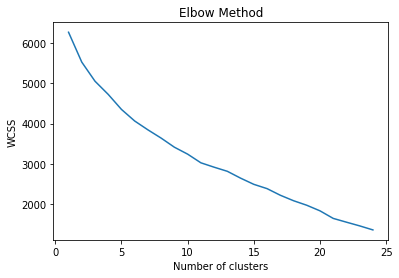

In [40]:
wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(corpus_embeddings)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

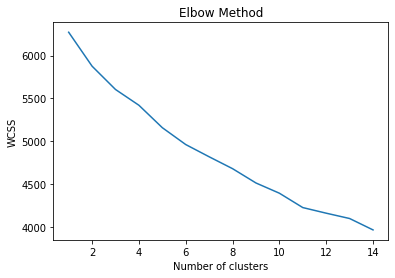

In [41]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(corpus_embeddings)
    wcss.append(kmeans.inertia_ + 500*math.log(i))
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [42]:
import numpy as np
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


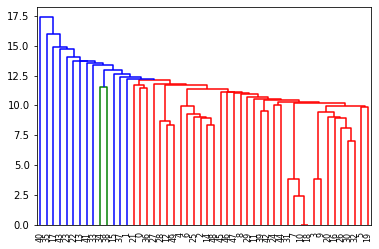

In [43]:
Z = hierarchy.linkage(corpus_embeddings, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)

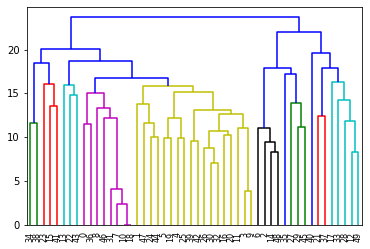

In [44]:
Z = hierarchy.linkage(corpus_embeddings, 'complete')
plt.figure()
dn = hierarchy.dendrogram(Z)

In [45]:
clustered_sentences[1]

# Most of the landslides are of uttrakhand, so clustering is working

["Six houses swept away as landslide hits Himachal's Kangra district | TV9News",
 'Himachal Pradesh: District Kangra Mein Landslide Se Bure Halat | Relief Ka Kaam Jari | News18 Urdu',
 'Kalsi Chakrata Road in Vikasnagar closed due to Landslide | Landslide viral video | Uttarakhand',
 'Landslide at Veling Priol Goankarwada',
 'Landslide in Utrakhand NH 7 . #shorts',
 'Himachal Pradesh: Massive landslide in Boh valley in Kangra district | KeralaKaumudi',
 'Due to the landslide mountain collapsed in Vikasnagar | Uttarakhand landslide viral video',
 'Ghar ke sath ho rha hai Landslide 🙄 |Jogi Jangam ki Kahani',
 'NH44 Ramban Update; Jammu Srinagar National Highway blocked due to landslide at Cafeteria Ramban',
 'Landslide',
 'Lyrical Group - Landslide',
 'Landslide in Abanda Majuwa',
 'Landslide in Himachal Pradesh',
 'Huge Landslide at Near by Chakrata road. Uttarakhand,India',
 'Uttarkashi Landslide | Heavy Rainfall | Weather | Uttarakhand | Gangotri Yamunotri Highway Closed']

# Keyword Extraction to recommend queries for focused crawler

In [48]:
%%capture
!pip install git+https://github.com/LIAAD/yake

In [49]:
import yake
language = "en"
max_ngram_size = 3
deduplication_thresold = 0.9
deduplication_algo = 'seqm'
windowSize = 1
numOfKeywords = 20
kw_extractor = yake.KeywordExtractor()

In [50]:
# Merging the description

# text = []
# irrelevant =[]
# for i in range(len(df_updated)) :
#   try :
#     temp = df_updated['Description'][i]
#     text.append(temp)
#   except :
#     irrelevant.append("")

#text = ''.join(str(text))

In [51]:
# Merging Video Titles to rank the most important events 
text = []
irrelevant =[]
for i in range(len(df_updated)) :
  try :
    temp = str(df_updated['Video_Title'][i])
    text.append(temp)
  except :
    irrelevant.append("")

In [52]:
text = ''.join(str(text))

In [54]:
# Yake Library Paper : https://repositorio.inesctec.pt/bitstream/123456789/7623/1/P-00N-NF5.pdf

kw_extractor = yake.KeywordExtractor()
keywords = kw_extractor.extract_keywords(text)

We can clearly notice below , we rank the important landslide events that our keyword extractor captured

In [55]:
for kw in keywords:
	print(kw)

('Himachal Pradesh Landslide', 0.00020404189251219105)
('Himachal flash flood', 0.0002857186874773786)
('Himachal Pradesh', 0.0004352167780294632)
('flash flood', 0.0004832808349338941)
('landslide hits Himachal', 0.0005518588024946492)
('Dharamsala flash floods', 0.0006017059557563751)
('Kangra Mein Landslide', 0.0006825772797378637)
('London flash floods', 0.0007412778985560565)
('Himachal Pradesh Floods', 0.0007421977345009992)
('hits Himachal Kangra', 0.0009608979621055371)
('landslide', 0.0009832376589994554)
('Floods Hit Himachal', 0.0010051718230212336)
('Himachal Kangra', 0.00101000047464106)
('triggers flash flood', 0.0011255869035312132)
('Uttarakhand Flash Flood', 0.0011674492472973361)
('Landslide viral video', 0.0013598251574753915)
('Uttarakhand landslide viral', 0.0014870553878369157)
('Himachal', 0.0015624931491615567)
('Rescue ops underway', 0.0016137046936749325)
('flood', 0.0016976368179103811)


# Finding Ranks/reccommendation using RAKE Library through our clustering

In [56]:
%%capture
!pip install rake_nltk

This is useful when we want to capture important events per cluster

In [57]:
import string
from rake_nltk import Rake
extracts=[[] for i in range(num_clusters)]
r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.
r = Rake(min_length=1, max_length=5)
for i in range(len(clustered_sentences)):
  text=' '.join(clustered_sentences[i])
  r.extract_keywords_from_text(text)
  print("Cluster",i,": ",r.get_ranked_phrases()[0:3]) # To get keyword phrases ranked highest to lowest.
  extracts[i] = ' '.join(r.get_ranked_phrases())

Cluster 0 :  ["disastrous ': inside trump ’", 'six houses swept away', 'tv9news kalsi chakrata road']
Cluster 1 :  ['dehradun vikasnagar river overflow', 'delhi ncr himachal pradesh landslide', '‘ flash flood ’']
Cluster 2 :  ['five still missing massive landslides', 'floods rescue ops underway', 'catch news himachal pradesh']
Cluster 3 :  ['veling priol goankarwada himachal pradesh', 'keralakaumudi landslide lyrical group', 'himachal pradesh huge landslide']
Cluster 4 :  ['bura haal ho gaya mera', 'relief ka kaam jari', 'bachaao yarr isse koi']


# Archives - OLD CODE

In [ ]:
# pip install date-extractor
# def ExtractDate(tweet):
#   tweet =str(tweet)
#   tweet = tweet.lower()
#   #tweet = re.sub(r'@[a-z0-9_]\S+' , '', tweet)
#   match = re.search(r"(\d+)[-.\/](\d+)[-.\/](\d+)", tweet)
#   date = extract_dates(tweet)
#   date = str(date)
#   return date
#ddf['dates_extracted'] = ddf['Description'].apply(ExtractDate)

In [ ]:
# def Keyword_extract(text):
#   most_imp=[]
#   kw_extractor = yake.KeywordExtractor()
#   keywords = kw_extractor.extract_keywords(text)
#   for kw in keywords:
#     most_imp.append(kw)
#     break
#   return most_imp

Hindi to English transliteration

In [ ]:
#!pip install mtranslate

In [ ]:
#from mtranslate import translate

In [ ]:
   # to_translate = 'नमस्ते कैसी हो तुम?'
   # print(translate(to_translate))
   # print(translate(to_translate, 'en'))
   # print(translate(to_translate, 'hi'))

In [ ]:
%%capture
!pip install google_trans_new

In [ ]:
from google_trans_new import google_translator  
  
translator = google_translator()  
translate_text = translator.translate('हेलो चीनी',lang_tgt='en')  
print(translate_text)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b3b9dd4-a27f-4475-aef1-6b87fc2efdf5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>